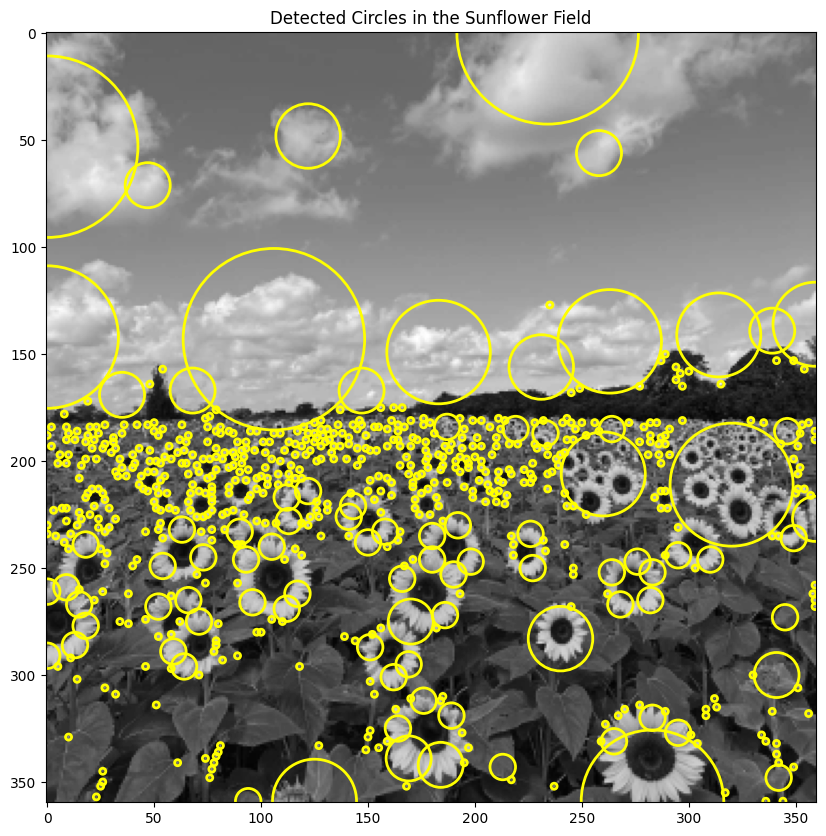

Parameters of the largest blobs (y, x, radius):
Blob 1: y = 0.0, x = 234.0, radius = 42.42640687119285
Blob 2: y = 53.0, x = 0.0, radius = 42.42640687119285
Blob 3: y = 143.0, x = 106.0, radius = 42.42640687119285
Blob 4: y = 359.0, x = 283.0, radius = 33.31258613589958
Blob 5: y = 142.0, x = 0.0, radius = 33.31258613589958
Range of σ values used: 1 to 30


In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import blob_log
from skimage.color import rgb2gray

# Load the image
im = cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)

# Convert the image to grayscale
im_gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)

# Normalize the grayscale image for better results
im_gray_normalized = im_gray / 255.0

# Use blob_log to detect blobs (circles)
blobs = blob_log(im_gray_normalized, max_sigma=30, num_sigma=10, threshold=0.1)

# Compute radii of the detected blobs (sqrt(2) * sigma)
blobs[:, 2] = blobs[:, 2] * np.sqrt(2)

# Create a figure to display results
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(im_gray, cmap='gray')

# Loop over the detected blobs and plot them
for blob in blobs:
    y, x, radius = blob
    circle = plt.Circle((x, y), radius, color='yellow', fill=False, linewidth=2)
    ax.add_patch(circle)

# Display the final image with detected circles
plt.title("Detected Circles in the Sunflower Field")
plt.show()

# Report the parameters of the largest blobs
largest_blobs = sorted(blobs, key=lambda b: -b[2])[:5]  # Top 5 largest blobs
print("Parameters of the largest blobs (y, x, radius):")
for i, blob in enumerate(largest_blobs):
    y, x, radius = blob
    print(f"Blob {i+1}: y = {y}, x = {x}, radius = {radius}")

# Report the range of σ values used
print("Range of σ values used: 1 to 30")
